In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
import warnings

In [2]:
# Suppress specific warnings
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")

In [3]:
# Custom helper functions
from helper_functions import evaluate_model

In [4]:
def plot(data, cols):
  # plot the time series data
  plt.figure(figsize=(15, 6))
  plt.plot(data[cols[0]], data[cols[1]])
  plt.title('TSF')
  plt.xlabel(cols[0])
  plt.ylabel(cols[1])
  plt.show()

In [54]:
def plot_model_results(train, test, forecast, forecast_train, label, cols, differencing=0):
    _train = train.copy()
    _test = test.copy()
    if differencing:
        _train = _train.iloc[differencing:]
        _test = _test.iloc[differencing:]

    # Plot Exponential Smoothing results
    plt.figure(figsize=(15, 6))
    plt.plot(train[cols[0]], train[cols[1]], label="Train", color='blue')
    plt.plot(test[cols[0]], test[cols[1]], label="Test", color='green')
    plt.plot(_train[cols[0]], forecast_train, label='In-sample Forecast', color='red')
    plt.plot(
        _test[cols[0]],
        forecast,
        label=label,
        color="orange",
    )
    plt.legend(loc="best")
    plt.show()

# Data: AMD Stock price

In [6]:
# Load dataset
loaded_data = pd.read_csv('amd.csv')

In [7]:
loaded_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2023-01-03,66.000000,66.879997,63.590000,64.019997,64.019997,46851800
1,2023-01-04,65.000000,65.790001,63.310001,64.660004,64.660004,47477100
2,2023-01-05,64.150002,64.349998,62.299999,62.330002,62.330002,46159500
3,2023-01-06,63.150002,64.300003,60.049999,63.959999,63.959999,70161300
4,2023-01-09,66.220001,69.320000,65.669998,67.239998,67.239998,69741300
...,...,...,...,...,...,...,...
311,2024-04-01,180.100006,187.240005,179.899994,183.339996,183.339996,74299900
312,2024-04-02,179.470001,180.100006,174.830002,178.699997,178.699997,61598800
313,2024-04-03,177.539993,182.050003,176.699997,180.770004,180.770004,49835100
314,2024-04-04,182.919998,183.020004,165.649994,165.830002,165.830002,88280000


In [8]:
loaded_data['date'] = pd.to_datetime(loaded_data['Date'])

In [9]:
# rename 'Adj Close' to 'price'
loaded_data.rename(columns={'Adj Close': 'price'}, inplace=True)

In [10]:
cols = ['date', 'price']
# cols = ['date', 'money']

# only keep the columns that we need
data = loaded_data[cols]
data = data.set_index(cols[0])

In [11]:
full_date_range = pd.date_range(start=data.index.min(), end=data.index.max())

In [12]:
data = data.reindex(full_date_range)

In [13]:
# fill missing values using linear interpolation
data.interpolate(method='linear', inplace=True)
# data.fillna(method='ffill', inplace=True)
data.index.name = 'date'
data.reset_index(inplace=True)

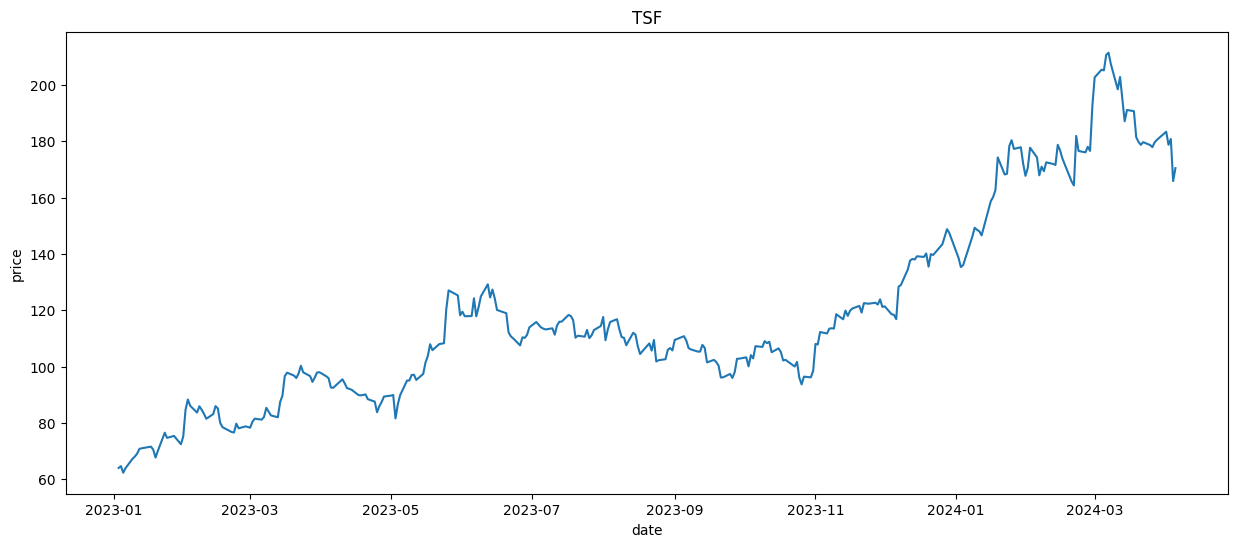

In [14]:
plot(data, cols)

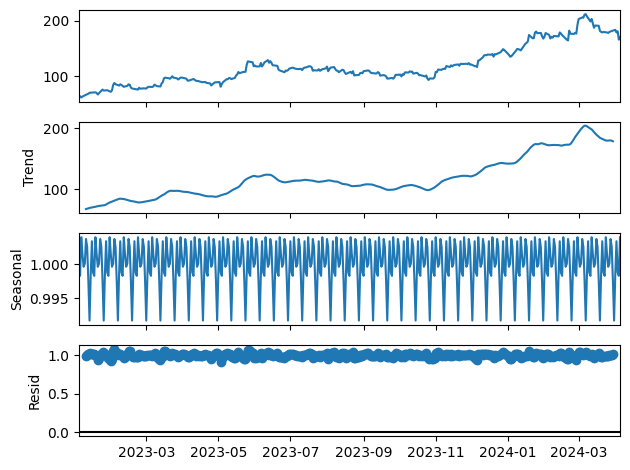

In [15]:
# seasonal decompose
result = seasonal_decompose(data.set_index('date'), model='multiplicative', period=12)
result.plot()
plt.show()

## Testing the need for differencing by using the Augmented Dickey-Fuller test

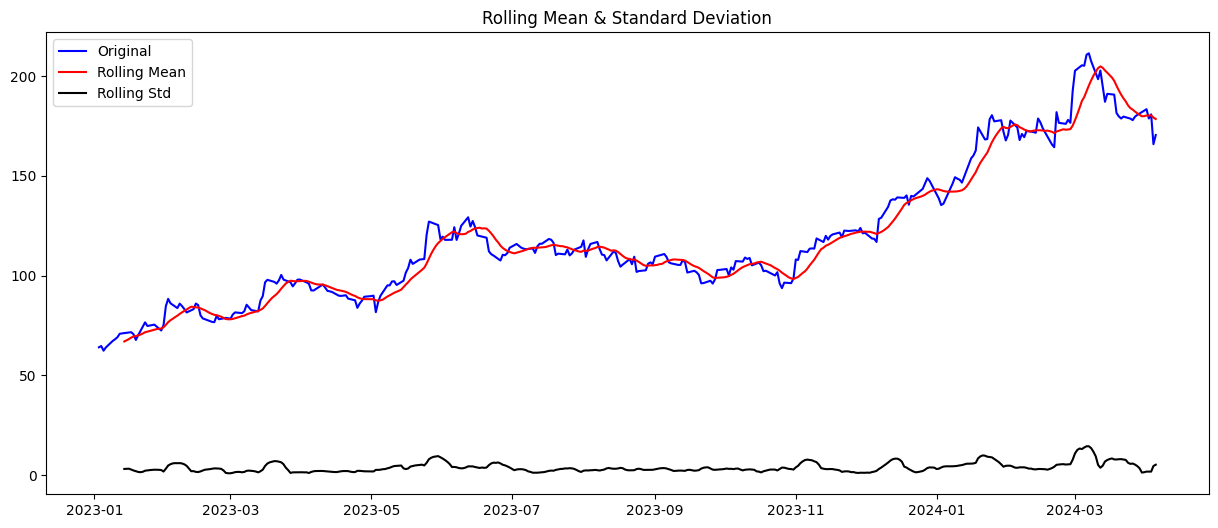

Results of Dickey-Fuller Test:
Test Statistic                  -0.979027
p-value                          0.760837
#Lags Used                       0.000000
Number of Observations Used    458.000000
Critical Value (1%)             -3.444709
Critical Value (5%)             -2.867871
Critical Value (10%)            -2.570142
dtype: float64


In [16]:
# stationary test
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    # Plot rolling statistics:
    plt.figure(figsize=(15, 6))
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.title('Rolling Mean & Standard Deviation')
    plt.legend()
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

test_stationarity(data.set_index(cols[0])[cols[1]])

## Differencing because p-value is greater than 0.05

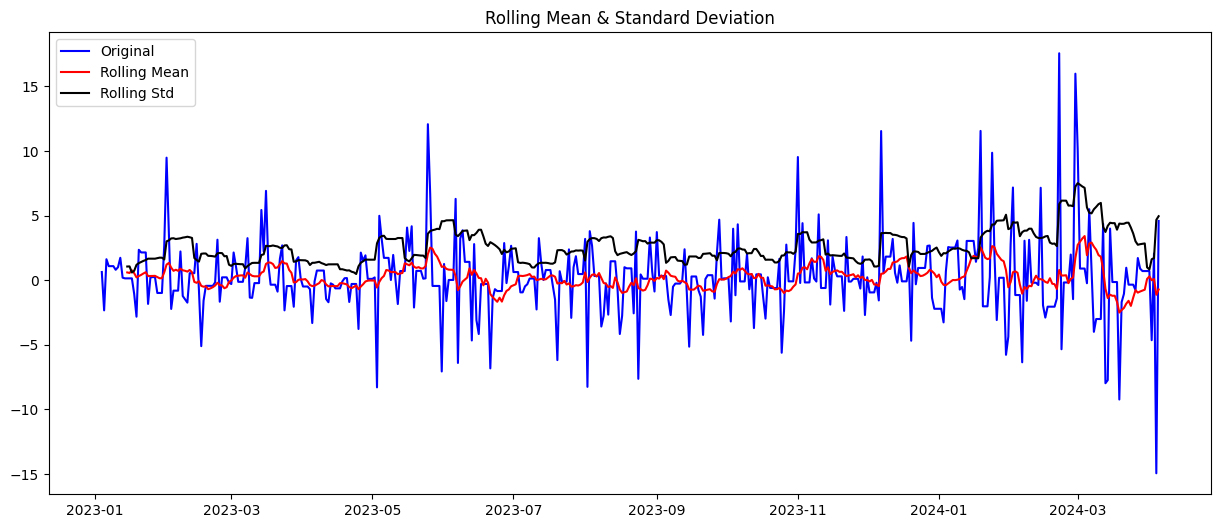

Results of Dickey-Fuller Test:
Test Statistic                 -20.772209
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    457.000000
Critical Value (1%)             -3.444740
Critical Value (5%)             -2.867885
Critical Value (10%)            -2.570150
dtype: float64


In [17]:
# the data is not stationary, we need to apply differencing
data['price_diff'] = data['price'] - data['price'].shift(1)
data.dropna(inplace=True)
test_stationarity(data.set_index('date')['price_diff'])
# cols = ['price_diff', cols[1]]

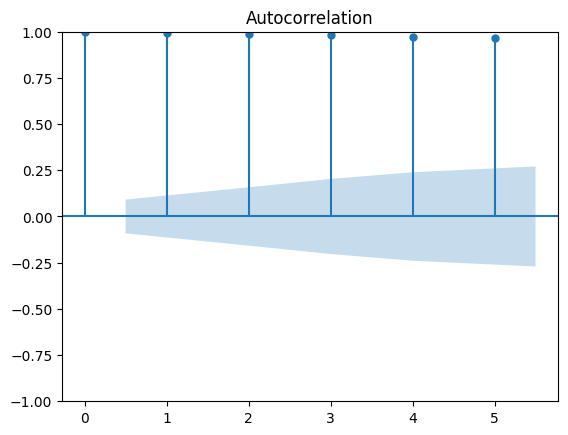

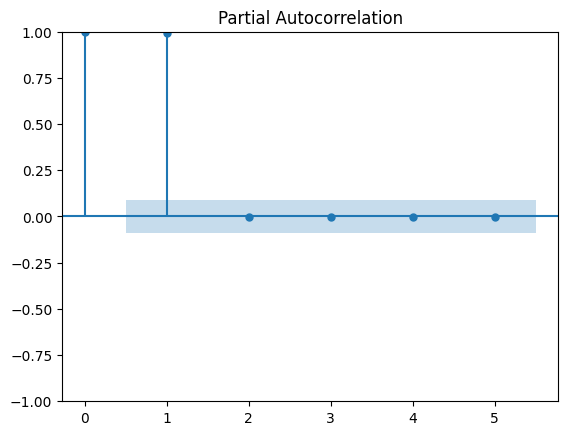

In [18]:
# generate ACF and PACF plots to determine the order of ARIMA model
col = cols[0]
plot_acf(data[col], lags=5)
plot_pacf(data[col], lags=5)
plt.show()

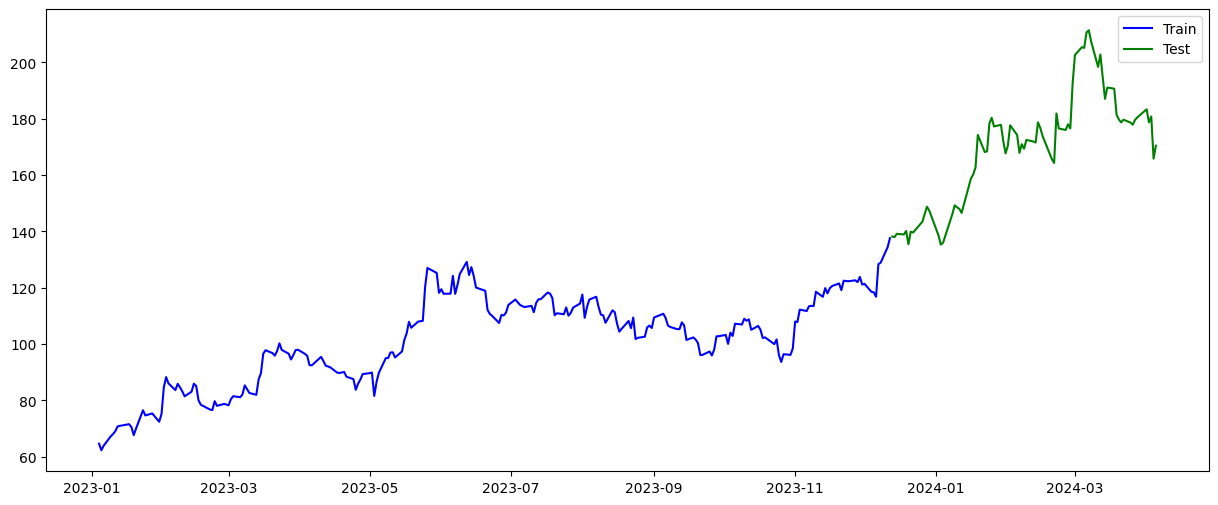

In [19]:
# train test split
train_size = int(len(data) * 0.75)
train, test = data[:train_size], data[train_size:]

# plot train and test data (with different colors - blue for train and green for test)
plt.figure(figsize=(15, 6))
plt.plot(train[cols[0]], train[cols[1]], label='Train', color='blue')
plt.plot(test[cols[0]], test[cols[1]], label='Test', color='green')
plt.legend(loc='best')
plt.show()

# Exponential Smoothing

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


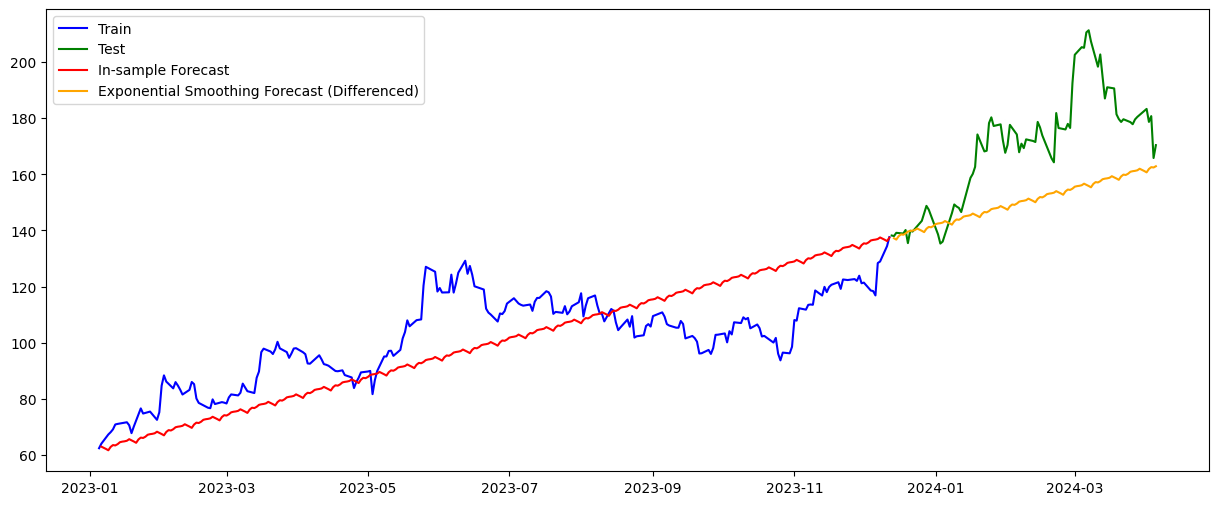

In [56]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import pandas as pd

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# Exponential Smoothing with differenced data
model_es = ExponentialSmoothing(
    train_diff.dropna(), seasonal="add", seasonal_periods=12
).fit()

# Forecast differenced data for the length of the test series
forecast_es_diff = model_es.forecast(len(test_diff))

# Reverting differencing for forecast
# We need to add the last observed value from the training set (train[cols[1]].iloc[-1])
forecast_es = forecast_es_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_es_diff = model_es.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_es = forecast_train_es_diff.cumsum() + train[cols[1]].iloc[0]

# Plot the model results
plot_model_results(
    train=train,
    test=test,
    label="Exponential Smoothing Forecast (Differenced)",
    forecast=forecast_es,
    forecast_train=forecast_train_es,
    cols=cols,
    differencing=1
)

# AR: Autoregression

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


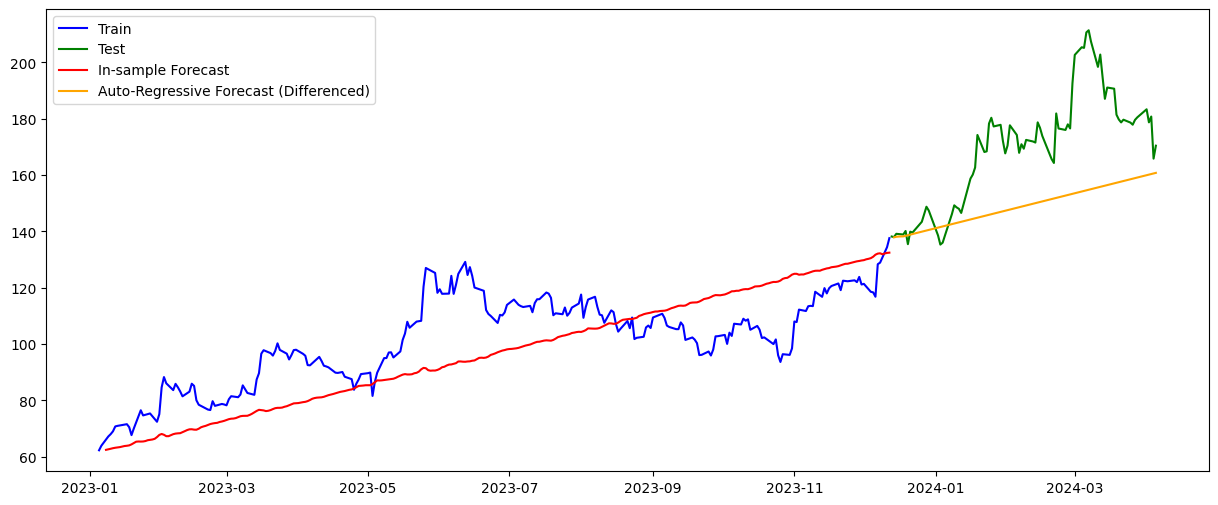

In [57]:
from statsmodels.tsa.ar_model import AutoReg
import pandas as pd

train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# Auto-Regressive Model with differenced data
model_ar = AutoReg(train_diff, lags=5).fit()
forecast_ar_diff = model_ar.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_ar = forecast_ar_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_ar_diff = model_ar.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_ar = forecast_train_ar_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="Auto-Regressive Forecast (Differenced)",
    forecast=forecast_ar,
    forecast_train=forecast_train_ar,
    cols=cols,
    differencing=1
)

# MA: Moving Average

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


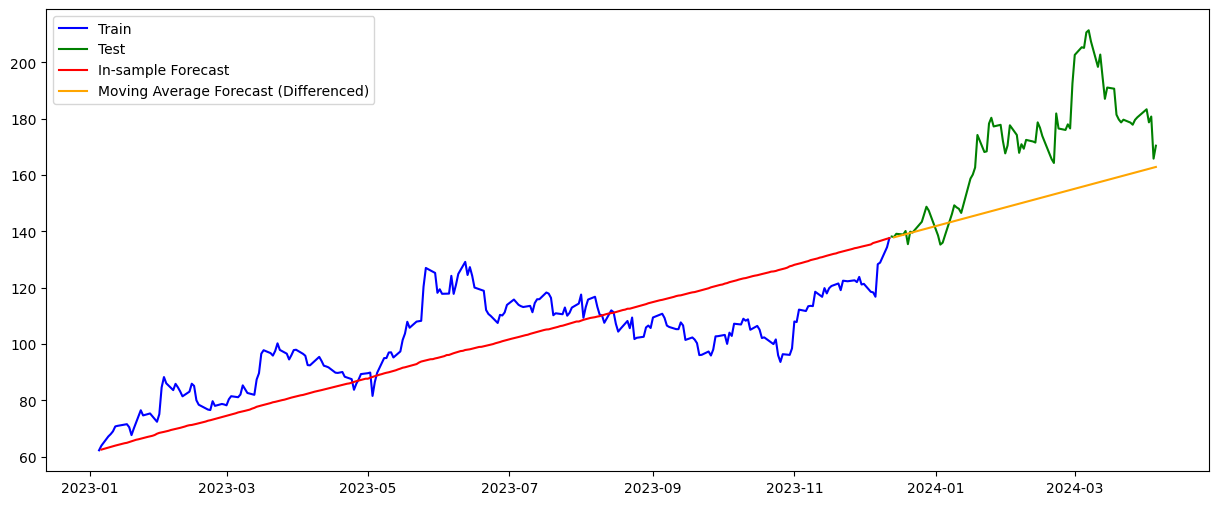

In [58]:
from statsmodels.tsa.arima.model import ARIMA

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# Fit an MA(1) model (ARIMA(0, 1, 1)) with differenced data
model_ma = ARIMA(train_diff, order=(0, 0, 1)).fit()
forecast_ma_diff = model_ma.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_ma = forecast_ma_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_ma_diff = model_ma.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_ma = forecast_train_ma_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="Moving Average Forecast (Differenced)",
    forecast=forecast_ma,
    forecast_train=forecast_train_ma,
    cols=cols,
    differencing=1
)

# ARIMA

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


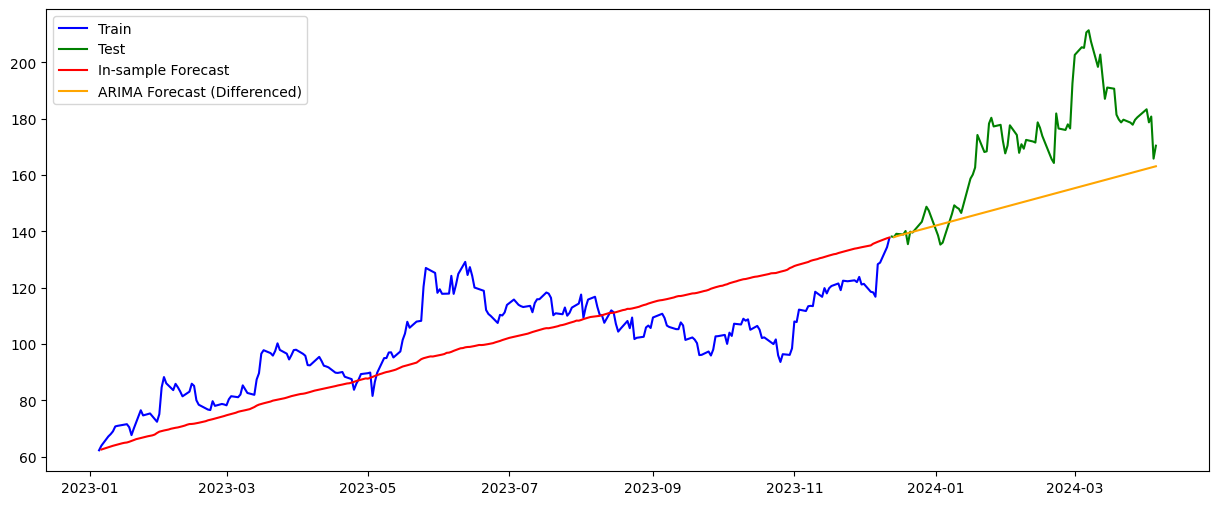

In [59]:
from statsmodels.tsa.arima.model import ARIMA

# Differencing to make series stationary
train_diff = train[cols[1]].diff().dropna()
test_diff = test[cols[1]].diff().dropna()

# ARIMA Model with differenced data
model_arima = ARIMA(train_diff, order=(1, 0, 1)).fit()
forecast_arima_diff = model_arima.forecast(steps=len(test_diff))

# Reverting differencing for forecast
forecast_arima = forecast_arima_diff.cumsum() + train[cols[1]].iloc[-1]

# Reverting differencing for in-sample forecast (train data)
forecast_train_arima_diff = model_arima.predict(start=train_diff.index[0], end=train_diff.index[-1])
forecast_train_arima = forecast_train_arima_diff.cumsum() + train[cols[1]].iloc[0]

plot_model_results(
    train=train,
    test=test,
    label="ARIMA Forecast (Differenced)",
    forecast=forecast_arima,
    forecast_train=forecast_train_arima,
    cols=cols,
    differencing=1
)

# SARIMA

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35228D+00    |proj g|=  1.17257D-01

At iterate    5    f=  2.26938D+00    |proj g|=  2.51275D-02

At iterate   10    f=  2.26075D+00    |proj g|=  7.27981D-03

At iterate   15    f=  2.26054D+00    |proj g|=  7.98640D-04

At iterate   20    f=  2.26030D+00    |proj g|=  5.26657D-03

At iterate   25    f=  2.26014D+00    |proj g|=  6.84614D-03

At iterate   30    f=  2.25993D+00    |proj g|=  1.11866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Users/youshaarshad/.pyenv/versions/3.12.4/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


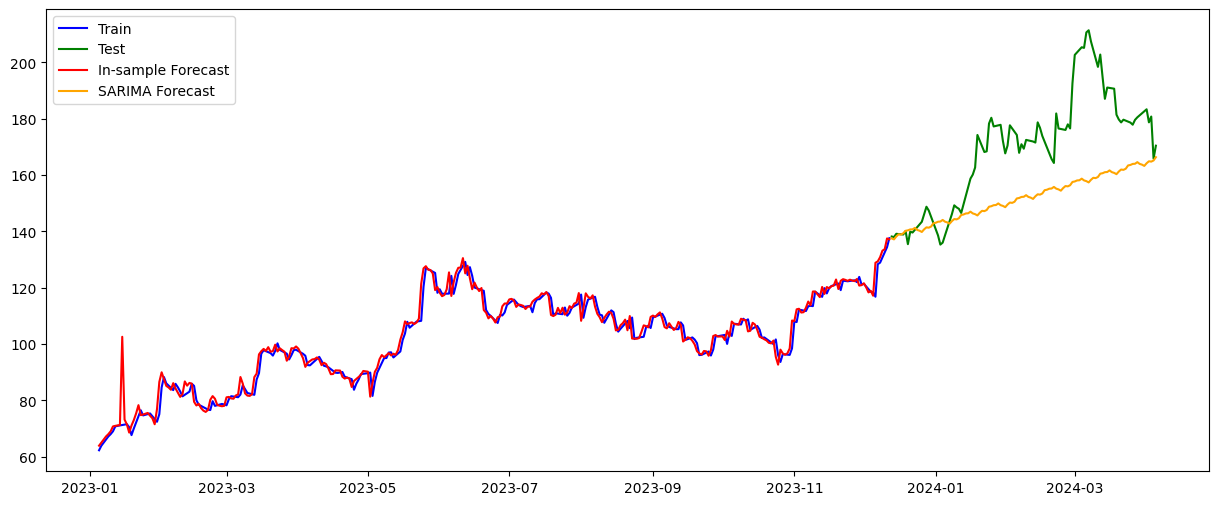

In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA Model
model_sarima = SARIMAX(train[cols[1]], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
forecast_sarima = model_sarima.forecast(steps=len(test))
# predict in sample (train data)
forecast_sarima_train = model_sarima.predict(start=train.index.min(), end=train.index.max())

plot_model_results(
  train=train,
  test=test,
  label="SARIMA Forecast",
  forecast=forecast_sarima,
  forecast_train=forecast_sarima_train,
  cols=cols,
)

In [74]:
_test = test[cols[1]][1:]
rmse_es, mae_es, r2_es, mape_es = evaluate_model(_test, forecast_es)
rmse_ar, mae_ar, r2_ar, mape_ar = evaluate_model(_test, forecast_ar)
rmse_ma, mae_ma, r2_ma, mape_ma = evaluate_model(_test, forecast_ma)
rmse_arima, mae_arima, r2_arima, mape_arima = evaluate_model(
    _test, forecast_arima
)
rmse_sarima, mae_sarima, r2_sarima, mape_sarima = evaluate_model(
    # _test, forecast_sarima
    test[cols[1]], forecast_sarima
)

# Define the metrics for each model
metrics = {
    "Model": ["ES", "AR", "MA", "ARIMA", "SARIMA"],
    "RMSE": [rmse_es, rmse_ar, rmse_ma, rmse_arima, rmse_sarima],
    "MAE": [mae_es, mae_ar, mae_ma, mae_arima, mae_sarima],
    "R2": [r2_es, r2_ar, r2_ar, r2_arima, r2_sarima],
    "MAPE": [mape_es, mape_ar, mape_ar, mape_arima, mape_sarima]
}

# Create DataFrame
scores_df = pd.DataFrame(metrics)
scores_df

,Model,RMSE,MAE,R2,MAPE
0,ES,24.214523,19.759526,-0.455221,0.108865
1,AR,25.383262,20.836637,-0.599087,0.114812
2,MA,24.175625,19.652678,-0.599087,0.114812
3,ARIMA,24.006671,19.477578,-0.430346,0.107148
4,SARIMA,22.621901,18.145123,-0.254605,0.099865


In [65]:
forecast_es

341    137.200218
342    136.732783
343    137.934050
344    138.589972
345    138.460429
          ...    
450    160.713166
451    161.914433
452    162.570355
453    162.440812
454    162.889153
Length: 114, dtype: float64

In [60]:
scores_df

,Model,RMSE,MAE,R2,MAPE
0,ES,37.606905,31.847785,-2.467240,0.176345
1,AR,48.296375,41.763022,-4.718444,0.232605
2,MA,70.739814,67.724708,-4.718444,0.232605
3,ARIMA,37.266926,31.445333,-2.404834,0.173928
4,SARIMA,22.431788,17.971664,-0.233606,0.098918
